# Product Category Classification with DistilBERT
*Fine-tuning a transformer to classify e-commerce product descriptions*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project uses Colab to take advantage of the GPU it offers. The first step is to mount Google Drive in Colab. Then, clone the repository if running for the first time or pull to get the latest synchronization. After that, run the setup file to ensure everything works correctly in the notebook.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Projects/Product-category-classifier
!git pull

/content/drive/MyDrive/Colab_Projects/Product-category-classifier
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 418 bytes | 2.00 KiB/s, done.
From https://github.com/herrerovir/Product-category-classifier
   0af5209..1693d80  main       -> origin/main
Updating 0af5209..1693d80
error: Your local changes to the following files would be overwritten by merge:
	notebooks/Product-category-classification.ipynb
Please commit your changes or stash them before you merge.
Aborting


In [3]:
# Import colab_up file
import colab_setup
colab_setup.setup(subdir = "notebooks")
from colab_setup import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/Product-category-classifier/notebooks


In [4]:
# Utilities
import pandas as pd
import re

# Modeling
from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

The dataset is read from a CSV file into a pandas DataFrame.

In [5]:
# Load dataset from CSV file
data = pd.read_csv(RAW_DIR / "ecomm_data.csv")
data.head()

,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [6]:
print(f"Original dataset shape: {data.shape}")

Original dataset shape: (50424, 2)


## Data Cleaning

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Rename Columns

Columns are renamed to improve clarity and consistency.

In [8]:
data.columns

Index(['Household', 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and s

In [9]:
# Rename columns for clarity
data = data.rename(columns = {data.columns[0]: "label", data.columns[1]: "product_description"})
data.head()

,label,product_description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


### Null Values

Rows containing null values are removed to maintain data integrity.

In [10]:
data.isna().sum()

,0
label,0
product_description,1


In [11]:
# Drop rows with missing values to ensure data quality
data = data.dropna()

In [12]:
print(f"Dropped missing values. New dataset shape: {data.shape}")

Dropped missing values. New dataset shape: (50423, 2)


### Duplicated Values

Rows with duplicate values in both columns are identified and removed.

In [13]:
full_dupes = data[data.duplicated()]
print(f"Full duplicate rows: {full_dupes.shape[0]}")

Full duplicate rows: 22622


In [14]:
# Show a sample of duplicated rows
full_dupes.head(10)

,label,product_description
6,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
10,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
11,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
15,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
19,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
20,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
21,Household,Incredible Gifts India Wooden Happy Birthday U...
22,Household,Posterhouzz Comics Superhero Thor Joker Black ...
23,Household,Indianara Motivational Square Synthetic Wood A...
26,Household,Painting Mantra Synthetic Wood Art Street Trop...


In [15]:
# Remove duplicates
data = data.drop_duplicates(subset = ["label", "product_description"])
print(f"Dataset shape after dropping duplicates: {data.shape}")

Dataset shape after dropping duplicates: (27801, 2)


### Class Balance

The distribution of class labels is reviewed to assess class balance.

In [16]:
label_dist = data["label"].value_counts(ascending = True)

In [17]:
# Useful for understanding label distribution
print("Label distribution:\n", label_dist)

Label distribution:
 label
Electronics                5308
Clothing & Accessories     5674
Books                      6256
Household                 10563
Name: count, dtype: int64


The dataset contains four product categories with a moderate class imbalance. The "Household" category represents the largest proportion, while "Electronics" is the smallest. Although the difference is not extreme, it may affect model performance. Monitoring class-wise metrics during evaluation is recommended to ensure balanced learning.

Text(0, 0.5, 'Count')

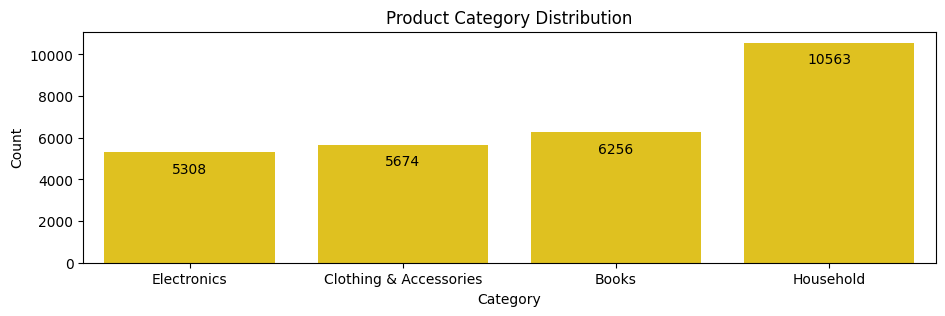

In [18]:
# Plot label counts
plt.figure(figsize = (11, 3))
ax = sns.barplot(x = label_dist.index, y = label_dist.values, color = "gold")

# Add counts on top of bars with formatted numbers
for i, count in enumerate(label_dist.values):
    ax.text(i, count -1000, f"{count}", ha = "center", fontsize = 10)

# Add labels and title
plt.title("Product Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")

### Label Enconding

Text labels are mapped to integer values for model compatibility.

In [19]:
# Convert textual category labels into integers
label_mapping = {
    "Electronics": 0,
    "Household": 1,
    "Books": 2,
    "Clothing & Accessories": 3
}

data["label"] = data["label"].map(label_mapping)

In [20]:
data.head()

,label,product_description
0,1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,1,SAF 'UV Textured Modern Art Print Framed' Pain...
2,1,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,1,Incredible Gifts India Wooden Happy Birthday U...
4,1,Pitaara Box Romantic Venice Canvas Painting 6m...


### Text Cleaning

Product descriptions are normalized by lowercasing, removing punctuation, and standardizing whitespace.

In [21]:
# Function to normalize and clean the product description text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()                         # Lowercase everything
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special chars
        text = re.sub(r"\s+", " ", text)            # Replace multiple spaces with one
        return text.strip()
    return ""

# Apply text cleaning
data["product_description"] = data["product_description"].apply(clean_text)

In [22]:
data.head()

,label,product_description
0,1,saf floral framed painting wood 30 inch x 10 i...
1,1,saf uv textured modern art print framed painti...
2,1,saf flower print framed painting synthetic 135...
3,1,incredible gifts india wooden happy birthday u...
4,1,pitaara box romantic venice canvas painting 6m...


### Shuffle the Data

The dataset is shuffled to ensure randomness before training.

In [23]:
# Shuffle to remove any learning bias due to ordering
data = shuffle(data, random_state = 42).reset_index(drop = True)